In this recipe we'll look at methods for outlier detection. We'll go through an example of outlier detection in a time-series with [Python Outlier Detection](https://pyod.readthedocs.io/en/latest/) (pyOD), a toolbox for outlier detection that implements many state-of-the-art methods and viualization. We'll apply an autoencoder for a similarity-based approach and then an online learning approach for an approach suitable for finding events in streams of data. The streams of data are timeseries of KPIs or CPU performance indicators provided with the [DONUT outlier detector](https://github.com/haowen-xu/donut).

Outlier detection is important in many domains including 
* network security, 
* finance, 
* traffic, 
* social media, 
* machine learning model performance monitoring, or 
* in surveillance.

A host of algorithms have been proposed for outlier detection in these domains. The most prominent algorithms inlude k-Nearest Neighbors (kNN), local outlier factors (LOF), and the isolation forest, and more recently autoencoders, long short-term memory (LSTM), and generative adversarial networks (GANs). 



In [0]:
!wget https://raw.githubusercontent.com/haowen-xu/donut/master/sample_data/cpu4.csv

--2020-01-28 13:59:35--  https://raw.githubusercontent.com/haowen-xu/donut/master/sample_data/cpu4.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463050 (452K) [text/plain]
Saving to: ‘cpu4.csv.2’

cpu4.csv.2          100%[===================>] 452.20K  --.-KB/s    in 0.04s   

2020-01-28 13:59:36 (12.6 MB/s) - ‘cpu4.csv.2’ saved [463050/463050]



In [0]:
import pandas as pd

In [0]:
cpu_data = pd.read_csv('cpu4.csv')

In [0]:
cpu_data.head()

,timestamp,value,label
0,1469376000,0.847300,0
1,1469376300,-0.036137,0
2,1469376600,0.074292,0
3,1469376900,0.074292,0
4,1469377200,-0.036137,0


In [0]:
from datetime import datetime


cpu_data['datetime'] = cpu_data.timestamp.astype(int).apply(datetime.fromtimestamp)

In [0]:
cpu_data.head()

,timestamp,value,label,datetime
0,1469376000,0.847300,0,2016-07-24 16:00:00
1,1469376300,-0.036137,0,2016-07-24 16:05:00
2,1469376600,0.074292,0,2016-07-24 16:10:00
3,1469376900,0.074292,0,2016-07-24 16:15:00
4,1469377200,-0.036137,0,2016-07-24 16:20:00


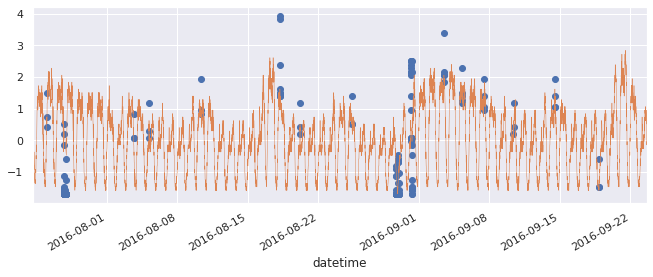

In [0]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

time_data = cpu_data.set_index('datetime')
time_data.loc[time_data['label'] == 1.0, 'value'].plot(linewidth=0.5, marker='o', linestyle='')
time_data.loc[time_data['label'] == 0.0, 'value'].plot(linewidth=0.5)

In [0]:
cpu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17568 entries, 0 to 17567
Data columns (total 4 columns):
timestamp    17568 non-null int64
value        17568 non-null float64
label        17568 non-null int64
datetime     17568 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 549.1 KB


In [0]:
len(cpu_data)

17568

In [0]:
pip install pyOD

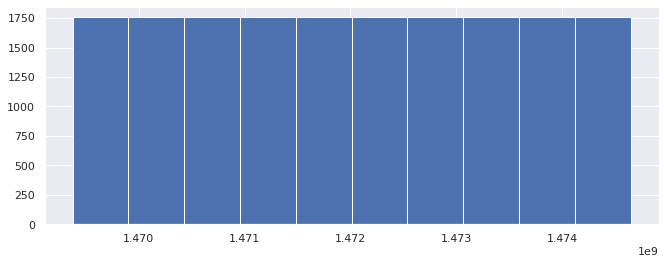

In [0]:
cpu_data.timestamp.hist()

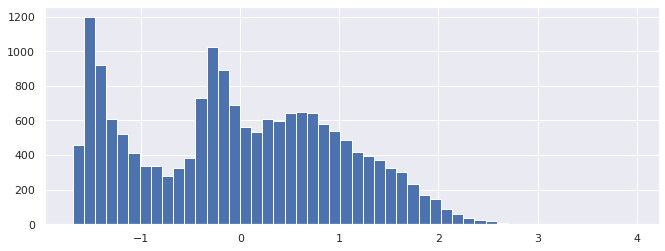

In [0]:
cpu_data.value.hist(bins=50)

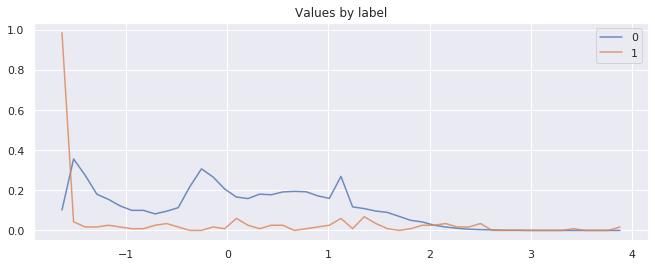

In [0]:
import numpy as np
from matplotlib import pyplot as plt


def hist2d(X, by_col, n_bins=10, title=None):
  '''plot two histograms against each other.

  I am using line plots here. Alternatively, 
  we could be using hist() with opacity.
  '''
  bins = np.linspace(X.min(), X.max(), n_bins)
  
  vals = np.unique(by_col)
  for val in vals:
    n, edges = np.histogram(X[by_col==val], bins=bins)
    n = n / np.linalg.norm(n)
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    plt.plot(bin_centers, n, alpha=0.8, label=val)

  plt.legend(loc='upper right')
  if title is not None:
    plt.title(title)
  plt.show()

hist2d(cpu_data.value, cpu_data.label, n_bins=50, title='Values by label')

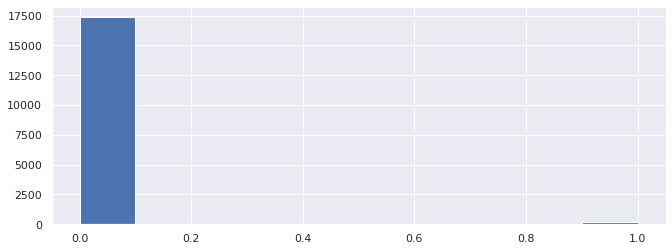

In [0]:
cpu_data.label.hist()

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cpu_data[['value']].values, cpu_data.label.values)

In [0]:
X_test.shape

(4392, 1)

In [0]:
# simplest example from the docs: train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores


In [0]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)



On Training Data:
KNN ROC:0.509, precision @ rank n:0.2143

On Test Data:
KNN ROC:0.4999, precision @ rank n:0.0


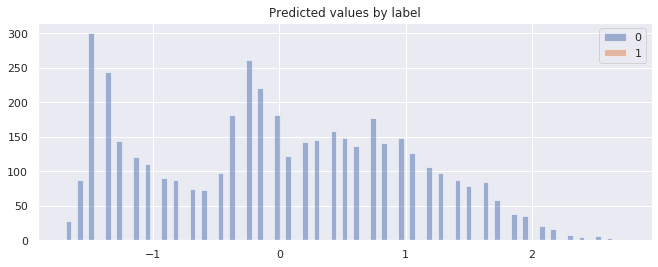

In [0]:
hist2d(X_test, y_test_pred, title='Predicted values by label')

Since this is prototype-based, it's not too surprising that this detector doesn't find any outlier: all points are similar to points shown before.

Let's show only examples that are not outliers. Let's also package this up a bit.

In [0]:
X_train[y_train==0.0].shape

(13016, 1)

In [0]:
X_train.shape

(13176, 1)

In [0]:
y_train.sum()

160

In [0]:
from pyod.utils.data import evaluate_print


def test_outlier_detector(X_train, y_train,
                          X_test, y_test, only_neg=True,
                          basemethod=KNN()):
  '''Test an outlier detection method on a dataset.
  This function trains a model, get performance metrics of
  the model, and plots a visualization.

  Parameters:
  -----------
  X_train : training features
  y_train : training labels
  X_test : test features
  y_test : test labels
  only_neg : whether to use only normal (i.e. not outliers) for training
  basemethod : the model to test
  '''

  clf = basemethod
  if only_neg:
    clf.fit(X_train[y_train==0.0], np.zeros(shape=((y_train==0.0).sum(), 1)))
  else:
    clf.fit(X_train, y_train)  # most algorithms ignore y

  y_train_pred = clf.predict(X_train)  # labels_
  y_train_scores = clf.decision_scores_

  y_test_pred = clf.predict(X_test)
  y_test_scores = clf.decision_function(X_test)

  print("\nOn Test Data:")
  evaluate_print(type(clf).__name__, y_test, y_test_scores)
  hist2d(X_test, y_test_pred, title='Predicted values by label')

/usr/local/lib/python3.6/dist-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")



On Test Data:
KNN ROC:0.4999, precision @ rank n:0.0


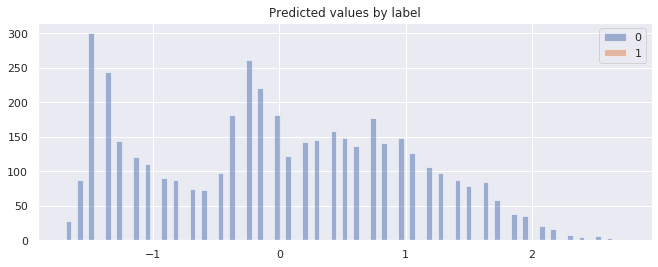

In [0]:
test_outlier_detector(X_train, y_train, X_test, y_test, only_neg=False, basemethod=KNN(n_neighbors=3, metric='hamming', method='mean', contamination=0.01))

In [0]:
type(AutoEncoder(hidden_neurons=[1], epochs=10)).__name__

'AutoEncoder'

/usr/local/lib/python3.6/dist-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1)                 2         
_________________________________________________________________
dropout_30 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 2         
_________________________________________________________________
dropout_31 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 2         
_________________________________________________________________
dropout_32 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)               

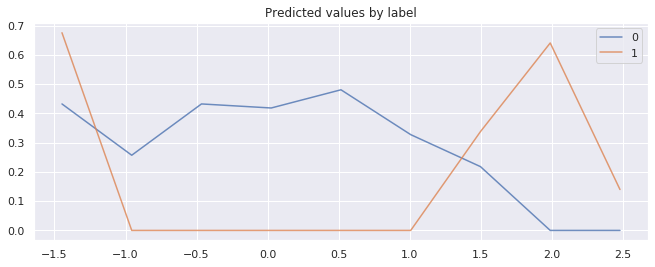

In [0]:
test_outlier_detector(
    X_train, y_train, X_test, y_test, 
    only_neg=False, basemethod=AutoEncoder(hidden_neurons=[1], epochs=10)
)



/usr/local/lib/python3.6/dist-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 1)                 2         
_________________________________________________________________
dropout_33 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 2         
_________________________________________________________________
dropout_34 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 2         
_________________________________________________________________
dropout_35 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)               

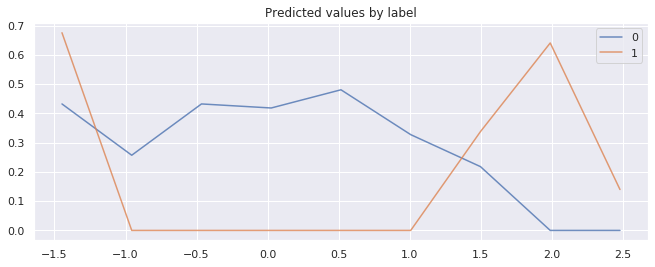

In [0]:
test_outlier_detector(
    X_train, y_train, X_test, y_test, 
    only_neg=True, basemethod=AutoEncoder(hidden_neurons=[1], epochs=10)
)



We didn't manage to get the KNN algorithm to work with our dataset, however, the autoencoder seems to work quite nicely, even though it incorrectly flags values in the upper range as well as in the lower range as we'd hoped.

/usr/local/lib/python3.6/dist-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



On Test Data:
LOF ROC:0.5, precision @ rank n:0.0


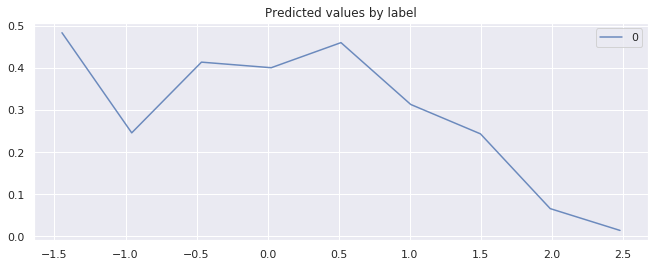

In [0]:
from pyod.models.lof import LOF

test_outlier_detector(
    X_train, y_train, X_test, y_test, 
    only_neg=False, basemethod=LOF(n_neighbors=2, contamination=0.01),
)

/usr/local/lib/python3.6/dist-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")



On Test Data:
IForest ROC:0.867, precision @ rank n:0.1


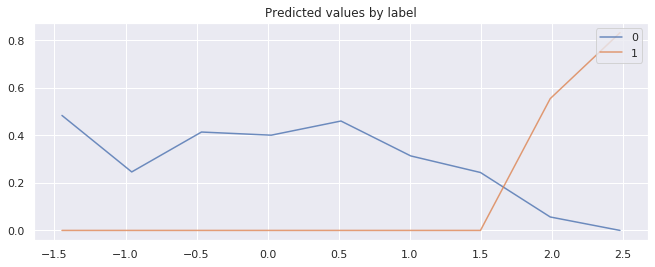

In [0]:
from pyod.models.iforest import IForest

test_outlier_detector(
    X_train, y_train, X_test, y_test, 
    only_neg=True, basemethod=IForest(contamination=0.01),
)

Many implementations for outlier detections are publicly available for python:

* As part of Numenta's [Cortical Learning Algorithm](http://nupic.docs.numenta.org/stable/guides/anomaly-detection.html#temporalanomaly-model)
* [Banpei](https://github.com/tsurubee/banpei) - singular spectrum transformation
* [Deep Anomaly Detection Methods for Time Series](https://github.com/KDD-OpenSource/DeepADoTS)
* [Telemanom](https://github.com/khundman/telemanom) - LSTMs for multivariate time-series data
* [DONUT](https://github.com/haowen-xu/donut) - Variational Auto-Encoder for Seasonal KPIs

A fantastic resource for [material about outlier detection](https://github.com/yzhao062/anomaly-detection-resources) is the PyOD author's dedicated repository.

